In [7]:
# imports
import numpy as np
from numpy import array, exp, zeros, sqrt, cos, sin, pi
from numpy.linalg import norm, inv
from scipy.linalg import expm
import matplotlib.pyplot as plt
import pandas as pd
from scipy.special import ellipj, ellipk

Q2.0
---

In [8]:
# Defining functions from previous assignments and quizzes

# diagonally implicit Runge-Kutta method solver
def dirk(f,Df, t0,y0, h, alpha,beta,gamma):
    m, s = len(y0), len(gamma)
    y = y0.copy().astype(float)
    k = np.zeros([s,m])
    for i in range(s):
        ti = t0+alpha[i]*h
        yi = y0.copy().astype(float)
        for j in range(i):
            yi += h*beta[i,j]*k[j]
        k[i,:] = f(ti,yi);
        if not beta[i,i] == 0:
            k[i,:],K = newton (lambda k: k-f(ti,yi+h*beta[i,i]*k),
                               lambda k: np.eye(m)-h*beta[i,i]*Df(ti,yi+h*beta[i,i]*k),
                               k[i,:], h*h*1e-5, 1000)
            assert K < 1000
        y += h*gamma[i]*k[i,:]
    assert( not np.any(np.isnan(y)) )
    return y

# Taylor series method
def taylor(f,Df,dtdf, t0,y0, h):
    y1 = y0 + h*f(t0,y0) + (1/2)*(h**2)*(dtdf(t0, y0) + np.dot(Df(t0, y0), f(t0, y0)))
    return y1

# newton method
def newton(F, DF, x0, eps, K):
    x = x0
    count = 0
    while (norm(F(x)) > eps) & (count < K):
        y = np.linalg.solve(DF(x), F(x))
        x -= y
        count += 1
    return x, count

# evolve method
def evolve(phi,f,Df, t0,y0, T,N):
    h = T/N # could also be h=(T-t0)/N
    y = np.zeros([N+1, len(y0)])
    t = np.zeros( N+1 )
    y[0] = y0
    t[0] = 0   # could be t[0]=t0
    for i in range(N):
        y[i+1] = phi(f,Df, t[i],y[i], h)
        t[i+1] = t[i]+h
    return t,y

# compute EOCs method
def computeEocs(herr):
    eoc_vals = []
    for i in range(0, len(herr[:,0])-1):
        eoc = np.log(herr[i+1,1]/herr[i,1])/np.log(herr[i+1,0]/herr[i,0])
        eoc_vals.append(eoc)
    eoc_vals = np.array(eoc_vals)
    return eoc_vals

Q2.1
---

,h,d = 0-error,d = 0-eoc,d=1/4-error,d=1/4-eoc,d = 1/2 + sqrt(3)/6-error,d = 1/2 + sqrt(3)/6-eoc
0,4.0000e-01,2.336009e-01,nan,1.980480e-02,nan,4.445094e-02,nan
1,2.0000e-01,5.724377e-02,2.029,5.230983e-03,1.921,8.023322e-03,2.470
2,1.0000e-01,1.252991e-02,2.192,1.295326e-03,2.014,1.206827e-03,2.733
3,5.0000e-02,2.894328e-03,2.114,3.279166e-04,1.982,1.694120e-04,2.833
4,2.5000e-02,6.889803e-04,2.071,8.193583e-05,2.001,2.265019e-05,2.903
5,1.2500e-02,1.680073e-04,2.036,2.048125e-05,2.000,2.928069e-06,2.952
6,6.2500e-03,4.148271e-05,2.018,5.120441e-06,2.000,3.724442e-07,2.975
7,3.1250e-03,1.030578e-05,2.009,1.280133e-06,2.000,4.696281e-08,2.987
8,1.5625e-03,2.568356e-06,2.005,3.200340e-07,2.000,5.896120e-09,2.994
9,7.8125e-04,6.410798e-07,2.002,8.000878e-08,2.000,7.386325e-10,2.997


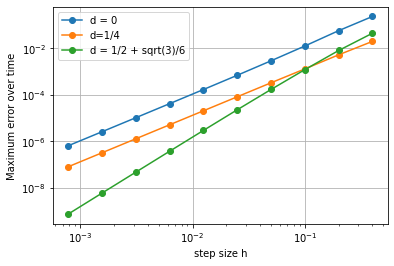

In [9]:
# Q2.1

#calculating the exact solution
def my_Y(t):
    y1 = (2*(np.e**t))/(2*(np.e**t)-1)
    y2 = (-2*(np.e**t))/(4*(np.e**(2*t)) - 4*(np.e**(t)) + 1)
    return np.array([y1, y2])

#writing right hand side of ODE
def f(t,y):
    return array([y[1], y[1]*(1-2*y[0])])

# Writing Df for above f
def Df(t,y):
    return array([[0,1],[-2*y[1],1-2*y[0]]])

# function to work out the errors and EOCs
def experiment(stepper, f,Df,T,Y, M,N0):
    herr = zeros( [M,2] )
    for m in range(M):
        N = N0*2**m
        try:
            t,y = evolve( stepper, f,Df, 0,Y(0),T, N)
            herr[m] = [T/N, max( norm(Y(t).transpose()-y,axis=1) )]
        except ValueError: # method not stable for given 'h'
            print("Error:", stepper,N,T/N,"failed: some NaN value produced!")
            herr[m] = [T/N, np.nan]
        except AssertionError: # assert in dirk was triggered (failed Newton)
            print("Error:", stepper,N,T/N,"failed: Newton function failed!")
            herr[m] = [T/N, np.nan]
    eoc = computeEocs( herr )
    eoc = np.hstack( [ [np.nan],eoc ] )
    res = np.hstack( [herr, np.atleast_2d(eoc).T] )
    return res

# function comparing the errors
def compareErrors(results):
    # columns of table
    simul = list(results.keys())
    columns=['h'] + [s for n in simul for s in [f'{n}-error', f'{n}-eoc']]
    # values in tablea
    keys = {columns[0]: results[simul[0]][:,0]} # all results are assumed to␣
    styles = {columns[0]: '{:.4e}'}
    for i, k in enumerate(simul):
        keys[columns[2*i+1]] = results[k][:,1] # errors
        styles[columns[2*i+1]] = '{:.6e}'
        keys[columns[2*i+2]] = results[k][:,2] # eocs
        styles[columns[2*i+2]] = '{:.3f}'
    # generate table
    table = pd.DataFrame(keys, index=range(results[simul[0]].shape[0]),columns=columns)
    display( table.style.format(styles) )
    for i,k in enumerate(simul):
        plt.loglog(results[k][:,0],results[k][:,1],marker='o',label=k)
    plt.legend()
    plt.grid(True)
    #plt.ylim([None, 1e8])
    plt.xlabel("step size h")
    plt.ylabel("Maximum error over time")
    plt.savefig("Q2_compareErr.pdf", format="pdf", bbox_inches="tight")
    plt.show()


# defining our Butcher Tableau
alpha_f = lambda d: np.array([d, 1-d])
beta_f = lambda d: np.array([[d, 0], [1-2*d, d]])
gamma = np.array([1/2, 1/2])

# defining our RK methods
method1 = lambda f,Df,t0,y0,h: dirk(f,Df,t0,y0,h,alpha_f(0),beta_f(0),gamma)
method2 = lambda f,Df,t0,y0,h: dirk(f,Df,t0,y0,h,alpha_f(1/4),beta_f(1/4),gamma)
method3 = lambda f,Df,t0,y0,h: dirk(f,Df,t0,y0,h,alpha_f((1/2) + np.sqrt(3)/6),beta_f((1/2) + np.sqrt(3)/6),gamma)

# calculating EOCs and errors
res1 = experiment(method1, f, Df, 10, my_Y, 10, 25)
res2 = experiment(method2, f, Df, 10, my_Y, 10, 25)
res3 = experiment(method3, f, Df, 10, my_Y, 10, 25)

# comparing errors and EOCs
compareErrors({"d = 0":res1, "d=1/4":res2, "d = 1/2 + sqrt(3)/6":res3})

Using a Theorem from the lectures we can easily determine from the Butcher tableau the consistency order and hence the convergence order of the RK methods.

When $d=0$ note that in the tableau the sum over the product of the $\alpha_i$ and $\gamma_i$ is $1/2$ hence converges with order 2. We see this in our results for the EOCs which appear to converge to 2 agreeing with the analytic result.

When $d=1/4$ note again that we have the sum over the product of the $\alpha_i$ and $\gamma_i$ is $1/2$ hence this RK method converges with order 2. Again our EOC result agrees with this as they appear to converge to 2 as $h$ decreases.

In the above cases of $d$ we did not satisy the criteria for convergence with order 3 from the theorem. However when $d=1/2 + \sqrt3/6$ this criteria is satisfied so the method converges with order 3. This agrees with our EOCs which converge to 3.

Q2.2/2.3
---

Results for initial value (0.05*pi, 0)


,h,DIRK d = 1/4-error,DIRK d = 1/4-eoc,eDIRK d = 1/4-error,eDIRK d = 1/4-eoc,DIRK d = 1/2 + sqrt(3)/6-error,DIRK d = 1/2 + sqrt(3)/6-eoc,eDIRK d = 1/2 + sqrt(3)/6-error,eDIRK d = 1/2 + sqrt(3)/6-eoc
0,2.0000e-01,1.251875e+00,nan,9.485810e-05,nan,6.537392e-01,nan,2.023538e-04,nan
1,1.0000e-01,7.578248e-01,0.724,2.315994e-05,2.034,5.406771e-01,0.274,2.970418e-05,2.768
2,5.0000e-02,2.055127e-01,1.883,5.757008e-06,2.008,1.549727e-01,1.803,3.926157e-06,2.919
3,2.5000e-02,5.162034e-02,1.993,1.444678e-06,1.995,2.411841e-02,2.684,4.965869e-07,2.983
4,1.2500e-02,1.292101e-02,1.998,3.610113e-07,2.001,3.176290e-03,2.925,6.230413e-08,2.995
5,6.2500e-03,3.230647e-03,2.000,9.035942e-08,1.998,4.037491e-04,2.976,7.766765e-09,3.004
6,3.1250e-03,8.076767e-04,2.000,2.270377e-08,1.993,5.081918e-05,2.990,9.086754e-10,3.095
7,1.5625e-03,2.019202e-04,2.000,5.441831e-09,2.061,6.373077e-06,2.995,3.080713e-10,1.561


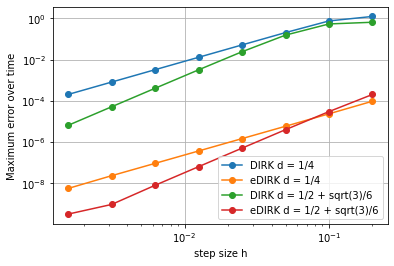

,h,DIRK d = 1/4-relative error,eDIRK d = 1/4-relative error,DIRK d = 1/2 + sqrt(3)/6-relative error,eDIRK d = 1/2 + sqrt(3)/6-relative error
0,2.0000e-01,9.852206e-07,1.121164e-06,1.246513e-02,7.158414e-06
1,1.0000e-01,2.532534e-07,2.690749e-07,1.218718e-02,1.037138e-06
2,5.0000e-02,6.389066e-08,6.660893e-08,5.231871e-03,1.344941e-07
3,2.5000e-02,1.598935e-08,1.661160e-08,8.481509e-04,1.695804e-08
4,1.2500e-02,3.997766e-09,4.150367e-09,1.103054e-04,2.123731e-09
5,6.2500e-03,9.992081e-10,1.037438e-09,1.387365e-05,2.655430e-10
6,3.1250e-03,2.497876e-10,2.593516e-10,1.736054e-06,3.319074e-11
7,1.5625e-03,6.244603e-11,6.483613e-11,2.170513e-07,4.255474e-12


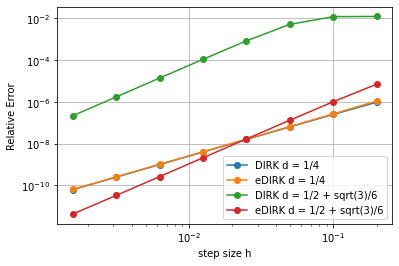

Results for initial value (0.6*pi, 0)


,h,DIRK d = 1/4-error,DIRK d = 1/4-eoc,eDIRK d = 1/4-error,eDIRK d = 1/4-eoc,DIRK d = 1/2 + sqrt(3)/6-error,DIRK d = 1/2 + sqrt(3)/6-eoc,eDIRK d = 1/2 + sqrt(3)/6-error,eDIRK d = 1/2 + sqrt(3)/6-eoc
0,2.0000e-01,2.601630e+00,nan,1.020247e+01,nan,1.004820e+01,nan,3.154612e+07,nan
1,1.0000e-01,6.420975e-01,2.019,2.779512e+00,1.876,1.177285e+01,-0.229,9.229287e+01,18.383
2,5.0000e-02,1.607761e-01,1.998,7.100328e-01,1.969,1.256500e+01,-0.094,1.333386e+01,2.791
3,2.5000e-02,4.011674e-02,2.003,1.779034e-01,1.997,9.939796e+00,0.338,5.256167e+00,1.343
4,1.2500e-02,1.002938e-02,2.000,4.449222e-02,1.999,1.349607e+00,2.881,6.694420e-01,2.973
5,6.2500e-03,2.507098e-03,2.000,1.112362e-02,2.000,1.702809e-01,2.987,8.354654e-02,3.002
6,3.1250e-03,6.267760e-04,2.000,2.781083e-03,2.000,2.130899e-02,2.998,1.044190e-02,3.000
7,1.5625e-03,1.566943e-04,2.000,6.952698e-04,2.000,2.664238e-03,3.000,1.305298e-03,3.000


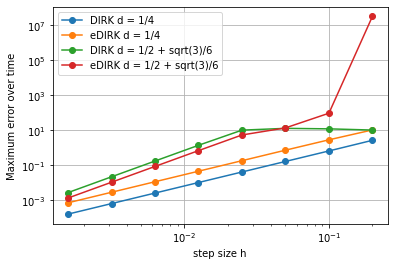

,h,DIRK d = 1/4-relative error,eDIRK d = 1/4-relative error,DIRK d = 1/2 + sqrt(3)/6-relative error,eDIRK d = 1/2 + sqrt(3)/6-relative error
0,2.0000e-01,3.665774e-02,1.243516e-02,4.236068e+00,9.756324e+13
1,1.0000e-01,9.222042e-03,3.877870e-03,4.013704e+00,4.792681e+01
2,5.0000e-02,2.309206e-03,9.574076e-04,1.020227e+00,6.652811e-01
3,2.5000e-02,5.775357e-04,2.386014e-04,1.359679e-01,6.907788e-02
4,1.2500e-02,1.443983e-04,5.960409e-05,1.717215e-02,8.483686e-03
5,6.2500e-03,3.610052e-05,1.489810e-05,2.150296e-03,1.057930e-03
6,3.1250e-03,9.025187e-06,3.724344e-06,2.689209e-04,1.322069e-04
7,1.5625e-03,2.256301e-06,9.310733e-07,3.361940e-05,1.652548e-05


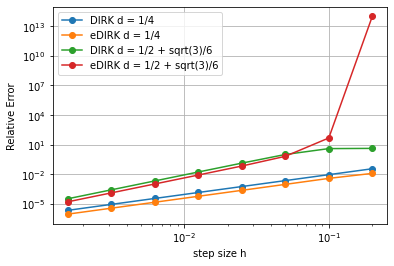

In [12]:
# Q 2.3

def eDirk(F, DF, t0, y0, h, alpha, beta, gamma, exphMs, exphMsInv, exphM):
    s = len(alpha)
    k_array = np.zeros((s, len(y0)))
    for i in range(s):
        my_sum = 0
        for j in range(i):
            my_sum += beta[i, j]*k_array[j, :]
        if beta[i,i] == 0:
            k_array[i,:] = exphMsInv[i].dot(F(t0+alpha[i]*h, exphMs[i].dot(y0 + h*my_sum)))
            
        else:
            f = lambda d: d - exphMsInv[i].dot(F(t0+alpha[i]*h, exphMs[i].dot(y0+h*(my_sum + beta[i,i]*d))))
            df = lambda d: np.eye(len(y0)) - h*beta[i,i]*DF(t0+alpha[i]*h, exphMs[i].dot(y0+h*(my_sum + beta[i,i]*d)))
            delta,_ = newton(f, df, exphMsInv[i].dot(F(t0+alpha[i]*h, exphMs[i].dot(y0 + h*my_sum))), h*h*1e-5, 1000)
            k_array[i,:] = delta
    phi = 0
    for l in range(s):
        phi += gamma[l]*k_array[l,:]
    y1 = exphM.dot((y0 + h*phi))
    return y1

# Defining Exact Solution for initial value (0.05*pi, 0)
x01 = 0.05*np.pi
k1 = np.sin(x01/2)
K1 = ellipk(k1*k1)
def Y1(t):
    sn, cn, dn, _ = ellipj(K1-4*t, k1*k1)
    x = 2*np.arcsin (k1*sn)
    p = 2/sqrt(1-(k1*sn)**2) * cn*dn * k1*(-4)
    return array([x,p])

# Defining Exact Solution for initial value (0.6*pi, 0)
x02 = 0.6*np.pi
k2 = np.sin(x02/2)
K2 = ellipk(k2*k2)
def Y2(t):
    sn, cn, dn, _ = ellipj(K2-4*t, k2*k2)
    x = 2*np. arcsin (k2*sn)
    p = 2/sqrt (1-(k2*sn)**2) * cn*dn * k2*(-4)
    return array ([x,p])

# Defining Hamiltonian RHS for DIRK method
def f1(t, y):
    return np.array([y[1], (-1)*np.sin(y[0])*(4**2)])

def Df1(t, y):
    return np.array([[0,1],[(-1)*(4**2)*np.cos(y[0]), 0]])

# defining M for eDIRK method
my_M = np.array([[0,1],[-16, 0]])

#function computing Hamiltonian
def H(y):
    x = y[0]
    p = y[1]
    return (1/2)*(p**2) - 16*np.cos(x)

# defining new experiment function
def edirk_experiment(f,Df,T,Y, M,N0, Matrix, alpha, beta):
    herr = zeros( [M,2] )
    arr = np.zeros((M,2))
    for m in range(M):
        N = N0*2**m
        my_h = T/N
        try:
            exphMs = []
            exphMsInv = []
            exphM = expm(my_h*Matrix)
            for i in range(len(alpha)):
                exphMs.append(expm(my_h*(alpha[i]*(Matrix))))
                exphMsInv.append(inv(expm(my_h*(alpha[i]*(Matrix)))))
            exphMsInv = np.array(exphMsInv)
            exphM = np.array(exphM)
            stepper = lambda f, Df, t0, y0, h: eDirk(lambda t,y:f(t,y) -Matrix.dot(y), 
                                        lambda t,y:Df(t,y)-Matrix, t0 ,y0 ,my_h,
                                        alpha,beta,gamma,
                                        exphMs , exphMsInv , exphM)
            t,y = evolve( stepper, f,Df, 0,Y(0),T, N)
            herr[m] = [T/N, max( norm(Y(t).transpose()-y,axis=1) )]
            # finding the relative errors
            N = N0*(2**m)
            h = T/N
            t, y = evolve(stepper, f, Df, 0, Y(0), T, N)
            Eh = 0
            for yn in y:
                new_error = np.abs(H(yn) - H(Y(0)))/np.abs(H(Y(0)))
                Eh = max(Eh, new_error)
            
            arr[m,0] = h
            arr[m,1] = Eh
            
        except ValueError: # method not stable for given 'h'
            print("Error:", stepper,N,T/N,"failed: some NaN value produced!")
            herr[m] = [T/N, np.nan]
        except AssertionError: # assert in dirk was triggered (failed Newton)
            print("Error:", stepper,N,T/N,"failed: Newton function failed!")
            herr[m] = [T/N, np.nan]
    eoc = computeEocs( herr )
    eoc = np.hstack( [ [np.nan],eoc ] )
    res = np.hstack( [herr, np.atleast_2d(eoc).T] )
    return res, arr

# carrying out experiments
resDIRK1_init1 = experiment(method2, f1, Df1, 100, Y1, 8, 500)
resDIRK2_init1 = experiment(method3, f1, Df1, 100, Y1, 8, 500)
res_eDIRK1_init1, ham_eDIRK1_init1 = edirk_experiment(f1, Df1, 100, Y1, 8, 500, my_M, alpha_f(1/4), beta_f(1/4))
res_eDIRK2_init1, ham_eDIRK2_init1 = edirk_experiment(f1, Df1, 100, Y1, 8, 500, my_M, alpha_f((1/2) + np.sqrt(3)/6), beta_f((1/2) + np.sqrt(3)/6))

resDIRK1_init2 = experiment(method2, f1, Df1, 100, Y2, 8, 500)
resDIRK2_init2 = experiment(method3, f1, Df1, 100, Y2, 8, 500)
res_eDIRK1_init2, ham_eDIRK1_init2 = edirk_experiment(f1, Df1, 100, Y2, 8, 500, my_M, alpha_f(1/4), beta_f(1/4))
res_eDIRK2_init2, ham_eDIRK2_init2 = edirk_experiment(f1, Df1, 100, Y2, 8, 500, my_M, alpha_f((1/2) + np.sqrt(3)/6), beta_f((1/2) + np.sqrt(3)/6))


def rel_e(stepper, M, N0, f, Df, Y, T):
    arr = np.zeros((M,2))
    for m in range(M):
        N = N0*(2**m)
        h = T/N
        t, y = evolve(stepper, f, Df, 0, Y(0), T, N)
        Eh = 0
        for yn in y:
            new_error = np.abs(H(yn) - H(Y(0)))/np.abs(H(Y(0)))
            Eh = max(Eh, new_error)
            
        arr[m,0] = h
        arr[m,1] = Eh
    return arr


#function to compare realtive errors
def compare_relErrors(results):
    # columns of table
    simul = list(results.keys())
    columns=['h'] + [s for n in simul for s in [f'{n}-relative error']]
    # values in tablea
    keys   = {columns[0]: results[simul[0]][:,0]} # all results are assumed to use the same sequence of h
    styles = {columns[0]: '{:.4e}'}
    for i, k in enumerate(simul):
        keys[columns[i+1]]   = results[k][:,1] # errors
        styles[columns[i+1]] = '{:.6e}'

    # generate table
    table = pd.DataFrame(keys, index=range(results[simul[0]].shape[0]), # all results must have the same shape
            columns=columns)

    # format floating points for each column for jupyter output (does not work in pdf)
    display( table.style.format(styles) )

    for i,k in enumerate(simul):
        plt.loglog(results[k][:,0],results[k][:,1],marker='o',label=k)
    plt.legend()
    plt.grid(True)
    plt.xlabel("step size h")
    plt.ylabel("Relative Error")
    plt.savefig("Q2_compareErr.pdf", format="pdf", bbox_inches="tight") # output to pdf for inclusing in tex document
    plt.show()

#calculating relative errors
ham_error_method2_init1 = rel_e(method2, 8, 500, f1,  Df1, Y1, 100)
ham_error_method3_init1 = rel_e(method3, 8, 500, f1,  Df1, Y1, 100)
ham_error_method2_init2 = rel_e(method2, 8, 500, f1,  Df1, Y2, 100)
ham_error_method3_init2 = rel_e(method3, 8, 500, f1,  Df1, Y2, 100)


# comparing max errors, EOCs and relative errors
print('Results for initial value (0.05*pi, 0)')
compareErrors({"DIRK d = 1/4":resDIRK1_init1, "eDIRK d = 1/4":res_eDIRK1_init1, "DIRK d = 1/2 + sqrt(3)/6":resDIRK2_init1, "eDIRK d = 1/2 + sqrt(3)/6":res_eDIRK2_init1})
compare_relErrors({"DIRK d = 1/4":ham_error_method2_init1, "eDIRK d = 1/4":ham_eDIRK1_init1, "DIRK d = 1/2 + sqrt(3)/6":ham_error_method3_init1, "eDIRK d = 1/2 + sqrt(3)/6":ham_eDIRK2_init1})
print('Results for initial value (0.6*pi, 0)')
compareErrors({"DIRK d = 1/4":resDIRK1_init2, "eDIRK d = 1/4":res_eDIRK1_init2, "DIRK d = 1/2 + sqrt(3)/6":resDIRK2_init2, "eDIRK d = 1/2 + sqrt(3)/6":res_eDIRK2_init2})
compare_relErrors({"DIRK d = 1/4":ham_error_method2_init2, "eDIRK d = 1/4":ham_eDIRK1_init2, "DIRK d = 1/2 + sqrt(3)/6":ham_error_method3_init2, "eDIRK d = 1/2 + sqrt(3)/6":ham_eDIRK2_init2})


Lets split the cases up into our different initial conditions:

$(x_0, p_0) = (0.05\pi, 0)$ :

Similar to Q2.1 we again see that the RK method with $d=1/4$ has EOCs converging to 2 which agrees with the consistency order being 2 which we worked out in Q2.1. We see from the table that the exponential version of this method also has EOCs converging to 2 but we also can note that the maximum errors of the exponential method are smaller than the original version

We also see the RK method with $d=1/2 + \sqrt3/6$ has EOCs converging to 3 again, as in Q2.1, agreeing with our analytical answer. The EOCs of the exponential method here don't appear to converge but we do see the maximum errors for this choice of $d$ are also much smaller for the exponential version of the method.

$(x_0, p_0) = (0.6\pi, 0)$ :
Similar to Q2.1 we again see that the RK method with $d=1/4$ has EOCs converging to 2 which agrees with the consistency order being 2. We see from the table that the exponential version of this method also has EOCs converging to 2 but we also can note that the maximum errors of the exponential method are this time larger than the original version.

We see the RK method with $d=1/2 + \sqrt3/6$ has EOCs converging to 3 again, as in Q2.1, agreeing with our analytical answer. The exponential version of the method also has EOCs converging to 3. We also see the maximum errors for this choice of $d$ are this time much larger for the exponential version of the method when h is small but as h gets smaller the maximum errors of the eDIRK method become smaller thant the ordinary method.

Now if we compare with our results from Q1.3 we can see consistencies. In our results, especially the graphs, for the conservation of the Hamiltonian we see for both inital conditions that for small enough h, $d=1/4$ outperforms the other value of d for all methods we have tested. In other words $d=1/4$ conserves the Hamiltonian better. For initial condition (0.05\pi, 0) the relative errors for $d=1/4$ start off larger than the relative errors for the exponential method with $d=1/2 + \sqrt3/6$. But as h becomes smaller the methods with $d=1/4$ come to have smaller relative errors, almost identical for the original and exponential method, implying they are conserving the Hamiltonian better.

This agrees with our result in Q1.3 that established for the RK method with the given Butcher tableau, $d=1/4$ is the only value of d that maintains quadratic invariances of the form $H(y) = y.Cy$. The Hamiltonian is of this form if we take $C=[[1/2, 1],[-1, \omega_0^2]]$ and $y = [p, \sqrt(cos(x))]$.